<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
    Understanding Time Series Processes and Pre-processing
              
</p>
</div>

Data Science Cohort Live NYC Feb 2022
<p>Phase 4: Topic 40</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>
    
    

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Time series are examples of sequential data:
- value at given time $Y[t]$
    1. might depend on value at previous times (e.g., $Y[t-1]$, $Y[t-2]$, etc) in some way


This is reasonable:
- past values of a time series affects the present value

- value at given time $Y[t]$
    2. also depends on dynamics (what governs change of $Y$ between time-values)
    


A very simple example: Brownian motion
- value at given time $Y[t]$
    - depends on value at previous time $Y[t-1]$
    - dynamics given by series of random impulses $\epsilon_t$

$$ Y[t] = Y[t-1] + \epsilon_t $$

where the random impulses $\epsilon_t$ sampled from a  normal distribution.

A visualization of Brownian motion in 2D:
    
<img src = "images/brownian.gif" >

Little particles impart small impulses:
- impulses $\epsilon_t$ drawn from distribution modeled by Normal/Gaussian centered around 0
- e.g. $\epsilon_t \approx N(y|0, \sigma)$

Modeling this in one dimension:

In [94]:
from scipy.stats import norm

def generate_1D_brownian(t):
    # initialize time series
    time_series = np.zeros((t))
    
    for t in np.arange(len(time_series)):
        time_series[t] = time_series[t-1] + norm.rvs(loc = 0, scale = 1, size = 1)
        
    return time_series


Function executes recurrence relation:

$$ Y[t] = Y[t-1] +\epsilon_t $$

With $\epsilon_t$ modeled by standard normal N(0,1)

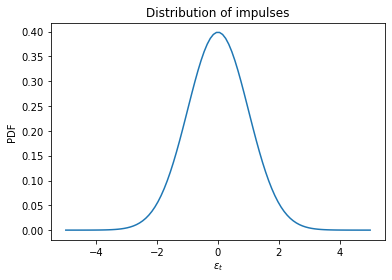

In [3]:
x_range = np.linspace(-5,5,100)
gauss = norm.pdf(x_range)

plt.plot(x_range, gauss)
plt.xlabel(r'$\epsilon_t$')
plt.ylabel('PDF')
plt.title('Distribution of impulses')

plt.show()

Running for different realizations on noise:

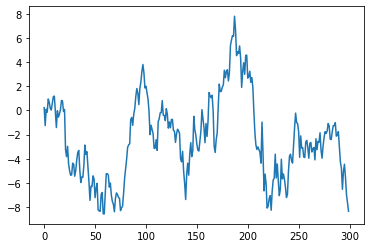

In [96]:
plt.plot(generate_1D_brownian(300))
plt.show()

- Clear influence of noise
- Also a clear notion of momentum (future depends on past)

Stocks often modeled as Brownian motion (or some modified version of it):
- Let's take in some Apple Stock data from 2015-2016 and have a gander.

In [5]:
#install this package which provides easy access to stock data
# !pip install yfinance 

In [97]:
# Import yfinance 
import yfinance as yf 

In [7]:
# Get the data for the stock Apple by specifying the stock ticker, start date, and end date 
data = yf.download('AAPL','2015-01-01','2016-12-01') 

[*********************100%***********************]  1 of 1 completed


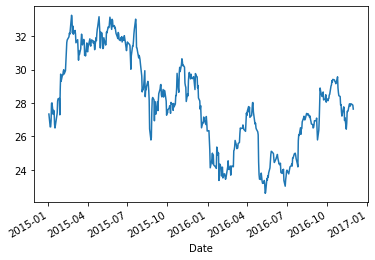

In [8]:
# Plot the close prices 
data.Close.plot() 
plt.show() 

Looks like this could be a Brownian process:

i.e. $$ Y[t] = Y[t - 1] + \epsilon_t $$

with $ \epsilon_t \approx N(0, \sigma) $ with $\sigma$ a parameter to be fit to.

If it is Brownian:
- the fluctuation kicks $\epsilon_t$ should be drawn from a normal distribution.

To evaluate this, we can take the difference between Y[t] and Y[t-1]:

- known as *first order differencing*

$$ Y[t] - Y[t-1] = \epsilon_t $$

First difference can be calculated using numpy/pandas .diff() method

In [9]:
first_difference = data.Close.diff()
first_difference

Date
2015-01-02 00:00:00-05:00         NaN
2015-01-05 00:00:00-05:00   -0.770000
2015-01-06 00:00:00-05:00    0.002501
2015-01-07 00:00:00-05:00    0.372499
2015-01-08 00:00:00-05:00    1.035000
                               ...   
2016-11-23 00:00:00-05:00   -0.142500
2016-11-25 00:00:00-05:00    0.139999
2016-11-28 00:00:00-05:00   -0.055000
2016-11-29 00:00:00-05:00   -0.027500
2016-11-30 00:00:00-05:00   -0.235001
Name: Close, Length: 483, dtype: float64

The values of this series are $\epsilon_t$ and should be normally distributed if Brownian:
- construct histogram

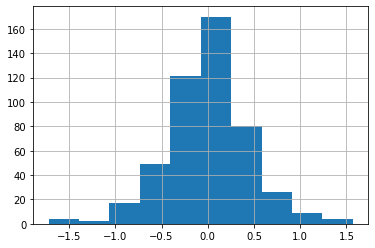

In [10]:
first_difference.hist()
plt.show()

This looks pretty well captured by a normal $N(0, \sigma)$

In [11]:
mu, sigma = norm.fit(first_difference.dropna())
mu

0.0006172172261471571

In [12]:
sigma

0.44400079865992126

Our stock price seems, by visualization, to be well modeled by a Brownian diffusion process:

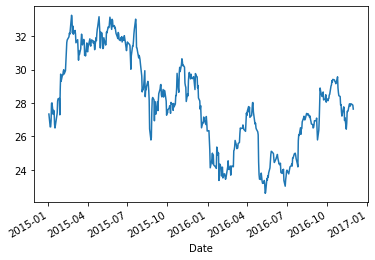

In [13]:
# Plot the close prices 
data.Close.plot() 
plt.show() 

where there is a notion that the past time-steps of a series affect the present.

i.e. in Brownian case: $$ Y[t] = Y[t - 1] + \epsilon_t $$


**Understanding and extracting these relationships directly from the data is the key to forecasting**

Since there is noise:
- relationship between between $Y[t]$ and $Y[t-1]$ is not exact.
- need a *statistical* relationship between $Y[t]$ and $Y[t-1]$, and other previous values

We can evaluate these statistical relationships directly from the data:
- i.e. evalute correlation between Y[t] and Y[t-1] across the different values of $t$ in time series.

Strictly speaking:
- how correlated is $Y[t]$ with a previous time-step $Y[t-\tau]$ 

- where $\tau$ is time steps back in the past: known as the **lag**

Defined in a familiar away as a Pearson correlation:

$$ K(\tau) = corr(Y[t], Y[t- \tau]) = \frac{Cov(Y[t], Y[t- \tau])}{\sigma_{Y[t]}\sigma_{Y[t-\tau]}} $$

Simplifies to:

$$ K(\tau) = \frac{Cov(Y[t], Y[t- \tau])}{Var[Y[t]]} $$

is the **autocorrelation** at lag $\tau$

Strictly speaking:
- how correlated is $Y[t]$ with a previous time-step $Y[t-\tau]$ 

- where $\tau$ is time steps back in the past: known as the **lag**

Calculating **autocorrelation** at lag $\tau$ from data:

$$ K(\tau) = \frac{\frac{1}{T}\sum_{i=1}^T (Y[t] -\bar{Y})(Y[t- \tau]- \bar{Y})}{Var[Y[t]]} $$


Doing this with pandas is no biggy:
    
- Let's do this for autocorrelation at lag 1:
    - .shift() operator by default shifts series by 1 row
    - calculate Pearson correlation between original series and shifted serries
    - Yields $K(1)$

In [14]:
Y_shifted = data.Close.shift(1)
Y_shifted

Date
2015-01-02 00:00:00-05:00          NaN
2015-01-05 00:00:00-05:00    27.332500
2015-01-06 00:00:00-05:00    26.562500
2015-01-07 00:00:00-05:00    26.565001
2015-01-08 00:00:00-05:00    26.937500
                               ...    
2016-11-23 00:00:00-05:00    27.950001
2016-11-25 00:00:00-05:00    27.807501
2016-11-28 00:00:00-05:00    27.947500
2016-11-29 00:00:00-05:00    27.892500
2016-11-30 00:00:00-05:00    27.865000
Name: Close, Length: 483, dtype: float64

In [15]:
data.Close

Date
2015-01-02 00:00:00-05:00    27.332500
2015-01-05 00:00:00-05:00    26.562500
2015-01-06 00:00:00-05:00    26.565001
2015-01-07 00:00:00-05:00    26.937500
2015-01-08 00:00:00-05:00    27.972500
                               ...    
2016-11-23 00:00:00-05:00    27.807501
2016-11-25 00:00:00-05:00    27.947500
2016-11-28 00:00:00-05:00    27.892500
2016-11-29 00:00:00-05:00    27.865000
2016-11-30 00:00:00-05:00    27.629999
Name: Close, Length: 483, dtype: float64

Calculating the Pearson correlation yields autocorrelation at lag 1:

In [99]:
new_df = pd.DataFrame(data.Close)
new_df['shifted_lag1'] = Y_shifted
new_df.corr()

,Close,shifted_lag1
Close,1.000000,0.987167
shifted_lag1,0.987167,1.000000


Calculating the autocorrelation of an ordered series at given lags is so common that there is a special Series method for it:
- Series.autocorr(lag)

In [17]:
# calculating the autocorrelation at lag 1
data.Close.autocorr(1)

0.987167218980087

Calculate autocorrelation at lag 2:
- using .shift() and calculating Pearson correlation
- using .autocorr()

In [104]:
# help a data science instructor out

shifted_lag2 = data.Close.shift(2)

new_df['shifted_lag2'] = shifted_lag2 

new_df.corr()

data.Close.autocorr(2)

0.974064215802471

In general:
- time series with positive autocorrelation at lag 1 have **momentum**
- time series with negative autocorrelation are **mean reverting**: 
    - fluctuations away from mean
    - next step goes towards the mean

<center><img src = "images/mean_reversion.png" ></center>

<center><img src = "images/momentum.png" ></center>

We can calculate the autocorrelation functions $K(\tau)$ out to multiple lags $\tau$:
- using statsmodels acf(nlags = )

In [105]:
from statsmodels.tsa.stattools import acf 

Let's calculate autocorrelation out to 5 lags

In [106]:
acf(data.Close, nlags = 5, fft = True)

array([1.        , 0.98707242, 0.9736706 , 0.96171567, 0.95062726,
       0.94107018])

In [21]:
# calculating the autocorrelation at lag 1
data.Close.autocorr(1)

0.987167218980087

In [22]:
# calculating the autocorrelation at lag 2
data.Close.autocorr(2)

0.974064215802471

Usually, the autocorrelation function is visualized:
- is the confidence interval range

In [107]:
from statsmodels.graphics.tsaplots import plot_acf

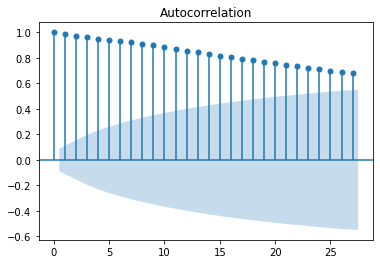

In [24]:
plot_acf(data.Close)
plt.show()

This in interesting: 
- correlation $ corr(Y_t, Y_{t-k}) $ decreases slowly with lag.
- this reflects notion that positive lag 1 autocorrelation implies a momentum.

- Time series $Y[t]$ can be indirectly correlated with $Y[t-2]$, $Y[t-3]$, etc...
- Correlation between $Y[t]$ and $Y[t-1]$ propagates step-by-step through time influencing values much later on: **momentum**

But what if we want to assess the *direct* influence that something that occurred many time steps ago has on the current time?

- i.e. subtracting out the influence from a given lag resulting purely from momentum.

**The Partial Autocorrelation Function**

Autocorelation at lag $\tau$ (correlation between $Y(t)$ and $Y(t - \tau))$ **conditioned on intervening values**: 
- i.e. given $Y[t-1]$, $Y[t-2]$,..., $Y[t-\tau + 1]$ are fixed

Math to calculate this directly is a little tricky but:

- can calculate this using statsmodels: .pacf()
- statsmodels also has a tool to plot this: .plot_pacf()

In [108]:
from statsmodels.tsa.stattools import pacf 
from statsmodels.graphics.tsaplots import plot_pacf

In [26]:
pacf(data.Close, nlags = 8)

array([ 1.        ,  0.98912029, -0.02956503,  0.05994467,  0.03028013,
        0.06780654,  0.00150456, -0.01703218, -0.08794618])

Blue band is region of a null on test that PACFs are equal to 0.

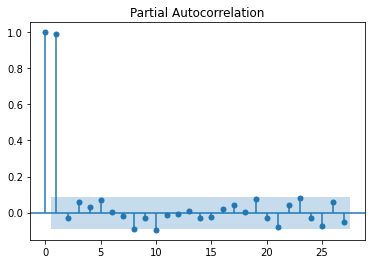

In [27]:
plot_pacf(data.Close)
plt.show()

What can be concluded from this plot?

The PACF shows us that past values of time series *directly* influencing $Y[t]$ is $Y[t-1]$:
- other lags affect $Y[t]$ only indirectly via momentum

Can construct a model reflecting this correlation structure from the data/statistics alone:


$$ Y[t] = \phi_1 Y[t-1] + \phi_2 Y[t-2] + ... + \epsilon_t $$

- where $\phi_1 = 1$ and all other $\phi_i$ are zero.

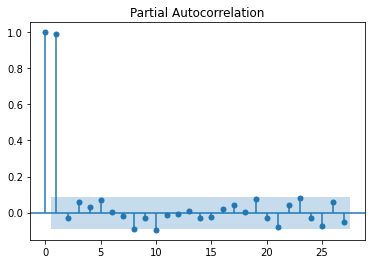

In [28]:
plot_pacf(data.Close)
plt.show()

Which is just Brownian motion/diffusion:

$$ Y[t] = Y[t-1] + \epsilon_t $$

ACFs and PACFs are often uses as an EDA tool:
- figure out what kind of time series models might be useful
- reflecting statistical correlation of time series

e.g., 

$$ Y[t] = \phi_1 Y[t-1] + \phi_2 Y[t-1] + ... + \epsilon_t $$

is an autoregressive (AR) model

Used ACF and PACF:

- to identify stock governed by AR(1) process.
- autogressive model up to lag 1

We will get more into these types of models, model order, and variants later.

#### Other components of a time series

Other factors affect time series beyond stochastic impulses and autocorrelations (momentum/mean reversion):
- trend
- seasonality

#### Trend

- very long-term increase/decrease
- i.e. slowly varying drift in the time series

In [29]:
google_df = pd.read_csv('data/google_stock.csv'
                       , index_col = [0],
                       parse_dates = True)
google_df = google_df.asfreq('1D').interpolate()
google_df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.470000,218.050000,209.320000,217.830000,1.313745e+07,GOOGL
2006-01-04,222.170000,224.700000,220.090000,222.840000,1.529235e+07,GOOGL
2006-01-05,223.220000,226.000000,220.970000,225.850000,1.081566e+07,GOOGL
2006-01-06,228.660000,235.490000,226.850000,233.060000,1.775952e+07,GOOGL
2006-01-07,230.253333,235.973333,228.133333,233.266667,1.610496e+07,NaN


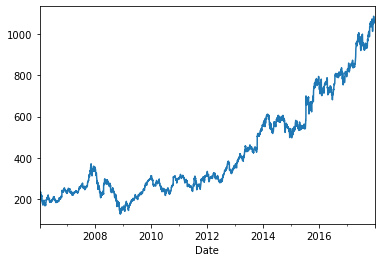

In [30]:
google_df.Close.plot()
plt.show()

Very clear, long-term upward trend that is likely not a result of momentum:

Very clear, long-term upward trend that is likely not a result of momentum:
- drift
- external (forcing) influences
- compounding effects

#### Seasonality

- natural periodic tendencies of a system (pendulums, etc)
- periodic influences (the effect of the moon on water depth: tides)

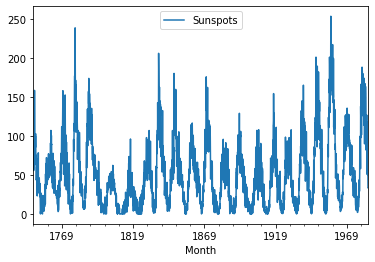

In [31]:
sunspots = pd.read_csv('data/monthly_sunspots.txt', index_col = [0], parse_dates = True)
sunspots.plot()
plt.show()

While there is noise, and some trend:
- solar activity governed by a set of periodic behaviors:
    - most prominent period at 11 years
    - 22 years is the full solar cycle
    - longer frequency periodic phenomena as well

In general a time series will be a combination/sum of some or all of these:

- trend
- seasonality
- autocorrelative phenomenon
- noise terms

Let's go back to our Google Close prices from 2006 to 2016:

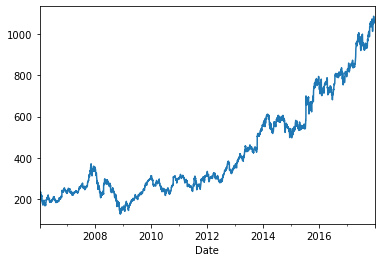

In [32]:
google_df.Close.plot()
plt.show()

Many ways to view the trend line separate from fluctuations in Python. Two equivalent ways:
- rolling mean methods
- seasonal decomposition

Using the rolling mean:
- take a large rolling window width
- smooth fluctuations to just get the trend line

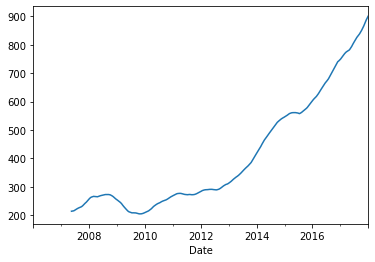

In [33]:
# we take a N = 500 windows size
google_df.Close.rolling(500).mean().plot()
plt.show()

Compare to original series:

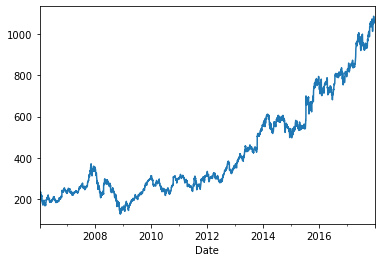

In [34]:
google_df.Close.plot()
plt.show()

Using the statsmodels decomposition:
- gets trend and seasonal components and then the rest

In [109]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(google_df.Close, period = 500)

Stores time series trend and residuals:
- trend over given period is equivalent to rolling mean smoothing over a window

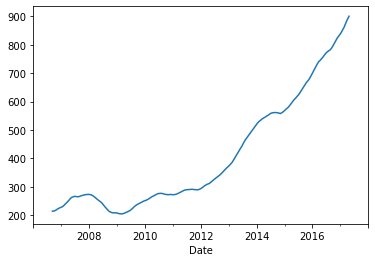

In [36]:
result.trend.plot()
plt.show()

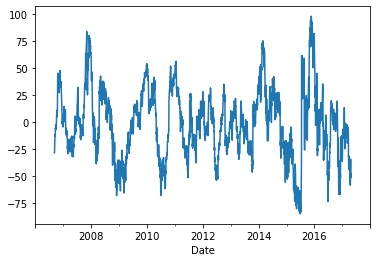

In [37]:
result.resid.plot()
plt.show()

The seasonal decomposition with periodic data:
- extracts seasonal components assuming inputted periodicity
- calculates trend / smooth data over this period
- extracts residuals

In [38]:
from scipy.stats import norm

T = 3653
x = np.linspace(0,3653,T)
f = 1/120
y = 0.8*np.sqrt(x) + 8*np.sin(2*np.pi*f*x) + 4*norm.rvs(loc = 0, scale = 1.5, size = T)
date_index = pd.date_range(start='2012-10-11', end='2022-10-11')

simple_seasonal = pd.Series(y, index = date_index)

Take a look at a simple series with trend and seasonality and noise:

In [110]:
simple_seasonal.head(10)

2012-10-11    -0.667769
2012-10-12    -0.173775
2012-10-13     3.846469
2012-10-14     6.162589
2012-10-15     5.100482
2012-10-16     5.459856
2012-10-17     0.562807
2012-10-18     0.585632
2012-10-19    15.210096
2012-10-20    -4.287353
Freq: D, dtype: float64

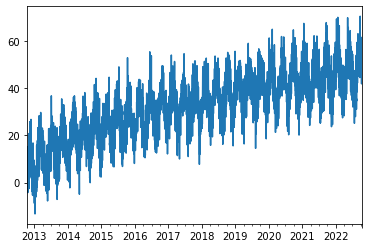

In [40]:
simple_seasonal.plot()
plt.show()

This time series has a periodicity of 120 days (4 months):
- specifying a known period, can use the seasonal decomposition to separate components

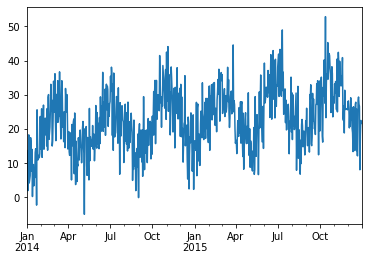

In [111]:
simple_seasonal.loc['2014':'2015'].plot()

plt.show()

In [112]:
# the period here is in lags in the time series:
# i.e 4 months = lag 120 for daily sampled series
result_seasonal = \
seasonal_decompose(simple_seasonal, period = 120)

Stores the result of the seasonal decomposition at a seasonal lag of 120.

Plotting the results of the decomposition:

In [113]:
%%capture decomposition_plot
fig, ax = plt.subplots(3,1, figsize = (6,6))
result_seasonal.trend.plot(ax = ax[0], label = 'trend')
ax[0].legend()
result_seasonal.seasonal.plot(ax = ax[1], label = 'seasonal')
ax[1].legend()
result_seasonal.resid.plot(ax = ax[2], label = 'residual')
ax[2].legend()

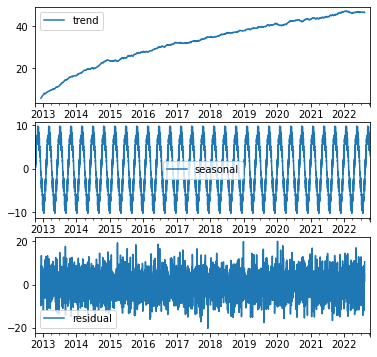

In [44]:
decomposition_plot()
plt.show()

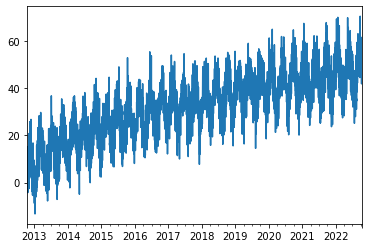

In [45]:
simple_seasonal.plot()
plt.show()

This is the original series.

In statistical time series modeling:
- interested in modeling the residual

**Residual** is the part of the model due to:
- non-deterministic signal autocorrelation
- noise terms

Typically trend and seasonality extracted via:
- rolling mean methods
- frequency space methods / spectrograms (won't cover this)

Subtracted from signal to get **residual**:
- residual input for classical time series modeling

By classical time series modeling, we mean direct decomposition of the time series signal $Y[t]$ (trend/seasonality removed):
- in terms of autoregressive correlation with previous values $Y[t-k]$
- noise terms $\epsilon_t$, etc.

i.e. an AR (autoregressive) model at order $k$ of form: 

$$ Y[t] = \sum_{i=1}^k \phi_k Y[t-k] + \epsilon_t $$

with $\phi_k$ being associated with the partial autocorrelation coefficients.

We've already seen something like this before when discovering the structure of the random walk.

A few assumptions in classical time series modeling:
- require that the autocorrelation structure does not change as a function of time
- time series expectation $E[Y]$ is not a function of time (no long term drift)
- time series variance $Var[Y]$ is not a function of time (no heteroskedasticity)

By static correlation structure we mean the $\phi_k$ are not functions of time.

$$ Y[t] = \sum_{i=1}^k \phi_k Y[t-k] + \epsilon_t $$


This property is known as **wide-sense or weak stationarity**

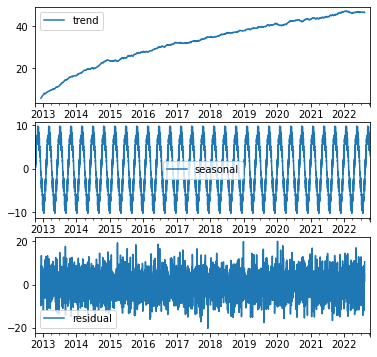

In [46]:
decomposition_plot()
plt.show()

This decomposition plot shows that the residual (which we might wish to model):
- is weak sense stationary 

The original series is not:

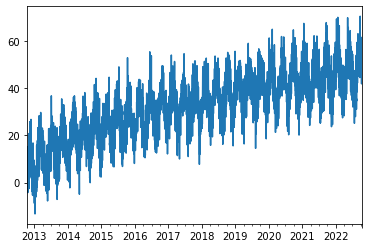

In [47]:
simple_seasonal.plot()
plt.show()

The trend and seasonality are **non-stationary** components of the time series:
- The mean/variance of the time series change with time.

Remove these and get the residual for modeling.

The residuals in above example appear to be drawn at random from the normal distribution:
- i.e. the stochastic part of the series is uncorrelated noise.

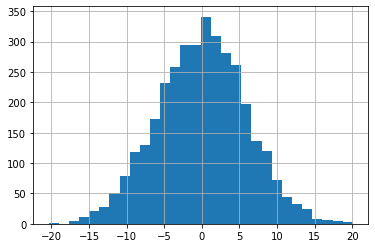

In [48]:
result_seasonal.resid.hist(bins = 30)
plt.show()

$$Y_{resid}[t] = \epsilon_t$$

with $ \epsilon_t \approx N(0, \sigma)$

also known as **Gaussian white noise process**.

Possibly the simplest of stationary processes.

Another less trivial wide-sense stationary process:
- AR(1) process

$$ Y[t] = 0.8 Y[t-1] + \epsilon_t $$

with $ \epsilon_t \approx N(0, \sigma) $

In [114]:
def generate_AR1(T, phi_1 ):
    # initialize time series
    time_series = np.zeros((T))
    
    for t in np.arange(len(time_series)):
        time_series[t] = phi_1*time_series[t-1] + norm.rvs(loc = 0, scale = 0.5, size = 1)
        
    return pd.Series(time_series)

<AxesSubplot:>

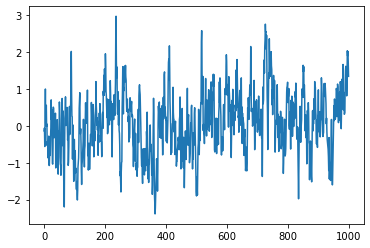

In [115]:
y_stat_AR1 = generate_AR1(T = 1000, phi_1 = 0.8)
y_stat_AR1.plot()

From visualization, there is a sense that:
- generating mean not changing
- standard deviation not changing

Way series is structured (correlations) not dependent on time.

This sense of stationarity places some requirements on the autoregression coefficients:

In terms of the autocorrelation coefficients: $\phi_k$

- in order to ensure stationarity
- $\phi_k$ must satisfy certain requirements
- i.e. for AR(1): $-1 < \phi_1 < 1$

$$ Y[t] = 0.8 Y[t-1] + \epsilon_t $$

with $ \epsilon_t \approx N(0, \sigma) $

If $|\phi_1| > 1$ we are bound to get an amplification of the time series:    

- not stationary

*Also $\phi$ no longer represent correlation coefficients*

Seeing this explosion in action:

<AxesSubplot:>

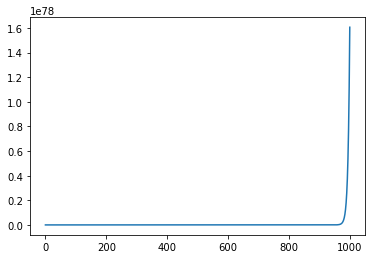

In [51]:
y_stat_AR_blowup = generate_AR1(T = 1000, phi_1 = 1.2)
y_stat_AR_blowup.plot()

Plotting visualization/examinations of stationarity are OK, but really a statistical test is needed.

#### Augmented Dickey-Fuller Test
- A test for wide-sense stationarity

In [116]:
from statsmodels.tsa.stattools import adfuller

In order to test stationarity:
- run the adfuller test on given time series.

**This is a left-tailed test on the augmented Fuller statistic and its governing distribution**

- The null $H_0$: Series is *not* wide-sense stationary
- The alternate $H_a$: Series is wide-sense stationary

<AxesSubplot:>

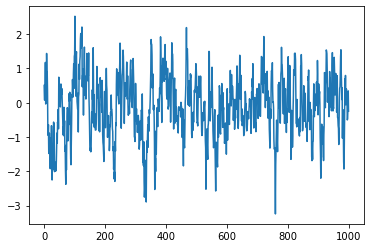

In [117]:
y_stat_AR1 = generate_AR1(T = 1000, phi_1 = 0.8)
y_stat_AR1.plot()

Conducting Augmented Dickey Fuller:

In [54]:
adfuller(y_stat_AR1)

(-10.046258470491916,
 1.4517747277678094e-17,
 0,
 999,
 {'1%': -3.4369127451400474,
  '5%': -2.864437475834273,
  '10%': -2.568312754566378},
 1389.6644663633963)

Critical value in rejection region at all the significance levels listed:

- p-value very low.


**Reject $H_0$**

Series is stationary.

On the other hand, let's look at what the Augmented Dickey-Fuller says for the other series:

<AxesSubplot:>

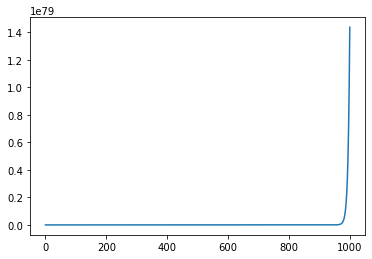

In [118]:
y_stat_AR_blowup = generate_AR1(T = 1000, phi_1 = 1.2)
y_stat_AR_blowup.plot()

In [119]:
adfuller(y_stat_AR_blowup)

(1.6589071400857693e+17,
 1.0,
 14,
 985,
 {'1%': -3.4370062675076807,
  '5%': -2.8644787205542492,
  '10%': -2.568334722615888},
 278976.85738461633)

p-value is 1. Cannot reject the null that series is non-stationary.

Finally, let's look at what the result is on the residual of the trend/seasonal decomposition of oscillating time series with trend:

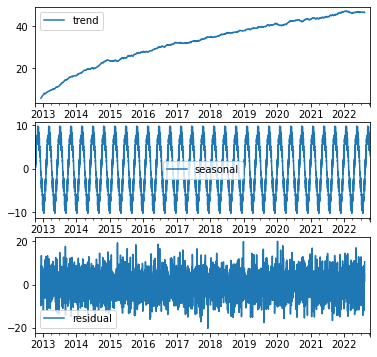

In [57]:
decomposition_plot()
plt.show()

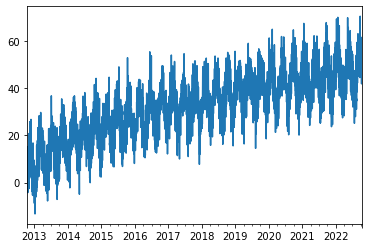

In [58]:
simple_seasonal.plot()
plt.show()

Conducting the Augmented Dickey Fuller tests on residuals:

In [59]:
adfuller(result_seasonal.resid.dropna())

(-34.13594004233741,
 0.0,
 2,
 3530,
 {'1%': -3.432203841817386,
  '5%': -2.8623591225627987,
  '10%': -2.567206032790569},
 22399.65411218432)

#### Series differencing:


A more common procedure to detrend/stationarize is to *difference* the series. If there is no seasonality, try differencing at lag 1. **Often creates a stationary series (removes trend)**.

In [120]:
def generate_AR1_lineartrend(T, phi_1, c ):
    # initialize time series
    time_series = np.zeros((T))
    
    for t in np.arange(len(time_series)):
        time_series[t] = c*t/T + phi_1*time_series[t-1] + norm.rvs(loc = 0, scale = .5, size = 1)
        
    return pd.Series(time_series)

In [128]:
ar_lintrend = generate_AR1_lineartrend(8000, 0.7, 1)

Is this stationary?

<AxesSubplot:>

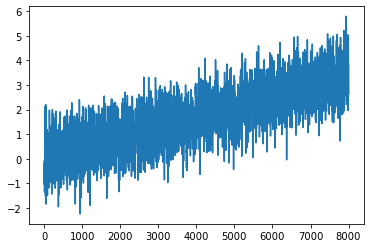

In [129]:
ar_lintrend.plot()

A Dickey-Fuller Test shows:

In [130]:
adfuller(ar_lintrend)

(-3.662739710919871,
 0.004668847703754597,
 36,
 7963,
 {'1%': -3.4311714754806224,
  '5%': -2.861903033070527,
  '10%': -2.5669632378194773},
 12000.279716950528)

Not stationary.

ACF/PACF looks funky:

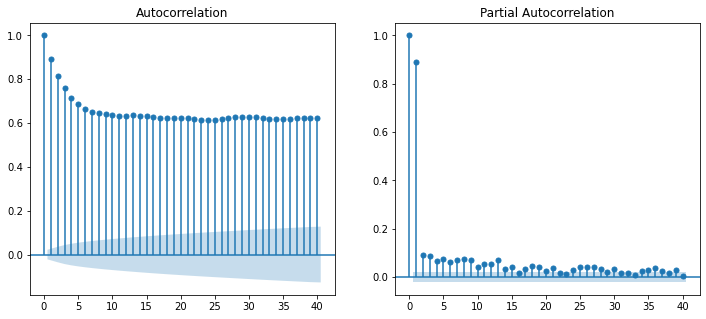

In [131]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
plot_acf(ar_lintrend, ax = ax[0])
plot_pacf(ar_lintrend, ax = ax[1])
plt.show()

ACFs that don't decay:
- sign that you may need to difference series.

So, what if we difference this series at lag 1? After differencing:

<AxesSubplot:>

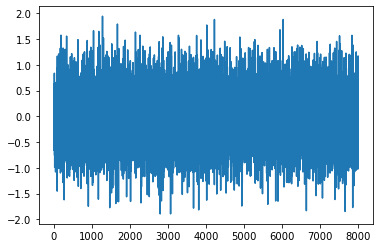

In [74]:
ar_lintrend_differenced = ar_lintrend.diff().dropna()
ar_lintrend_differenced.plot()

In [75]:
adfuller(ar_lintrend_differenced.dropna())

(-24.81069324577169,
 0.0,
 35,
 7963,
 {'1%': -3.4311714754806224,
  '5%': -2.861903033070527,
  '10%': -2.5669632378194773},
 11774.910259878017)

Can reject the null. Thus: this series is stationary.

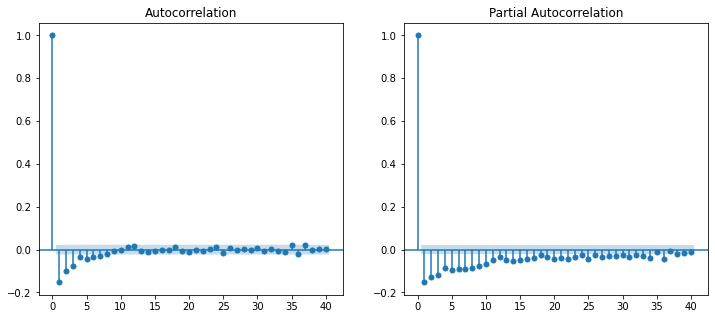

In [70]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
plot_acf(ar_lintrend_differenced, ax = ax[0])
plot_pacf(ar_lintrend_differenced, ax = ax[1])
plt.show()

Looks better: may need to difference again but likely we are fine (often one differencing operation will yield stationarity)
- Then interpret ACF/PACF on differenced series to assess model class and order
- Or to assess whether helpful to difference more


**Note: Assessing the minimum number of differencing operations important when moving to model development**

When confronted with seasonality:
- trend and seasonality removal through the decomposition techniques can be used:
    - analyze residual
    
In the more common modeling framework:
- trend differencing: we'll need to difference at lag 1 for trend
- seasonal differencing: at lag T_k for the each possible seasonal component $k$ with periodicity $T_k$

This can get time consuming but is the way it is done (as we'll see)

#### Multiplicative Series

**Additive Time Series**

So far have looked at time series where:

$$Y[t] = c + seasonal + \sum_{i=1}^N \phi_iY[t-i] + \epsilon_t $$

correlative effects from previous steps **add** with noise and trend and seasonality

**Multiplicative Time Series**

$$Y[t] = trend*noise*seasonality*\Pi_{i=1}^N \phi_iY[t-i] $$ 

A simple example:

$$Y[t] = Y[t-1]Y[t-2]Y[t-3]...Y[t-N] $$

correlative effects from previous steps **multiply** along with noise and trend and seasonality

These time series tend to have:
- exponential behavior
- noise amplifies over time
- seasonal oscillations grow multiplicatively larger.

Can anyone think of such a time series?

**Compounded interest.**

An example with some real data:

In [76]:
airline_df = pd.read_csv('data/airlinepassengers.txt', header=0, index_col=0, parse_dates = True)
airline_df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [77]:
airline_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


Visualizing the series:

<AxesSubplot:xlabel='Month'>

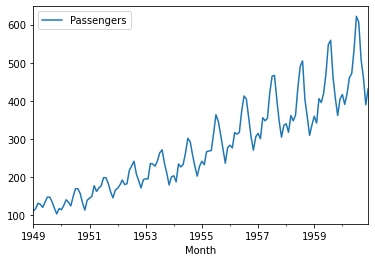

In [78]:
airline_df.plot()

A linear trend but there seems to be multiplicative seasonality:

- seasonal component increasing with each cycle.

A multiplicative model can be decomposed as follows:

In [79]:
result_airline = seasonal_decompose(airline_df, model='multiplicative') # assume multiplicative model

In [80]:
%%capture airline_decomposition_plot
fig, ax = plt.subplots(3,1, figsize = (6,6))
result_airline.trend.plot(ax = ax[0], label = 'trend')
ax[0].legend()
result_airline.seasonal.plot(ax = ax[1], label = 'seasonal')
ax[1].legend()
result_airline.resid.plot(ax = ax[2], label = 'residual')
ax[2].legend()

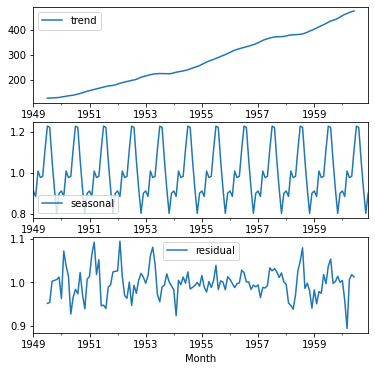

In [81]:
airline_decomposition_plot()

And to reconstruct the series:

<AxesSubplot:xlabel='Month'>

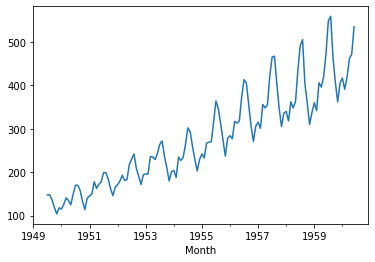

In [82]:
reconstruct = result_airline.trend*result_airline.seasonal*result_airline.resid

reconstruct.plot()

One thing to do then is model the residual:
- using standard classical time series methods if it is stationary

Another way sometimes used is to log transform the data:
- then start differencing: if seasonal then difference with seasonal lag as well

<AxesSubplot:xlabel='Month'>

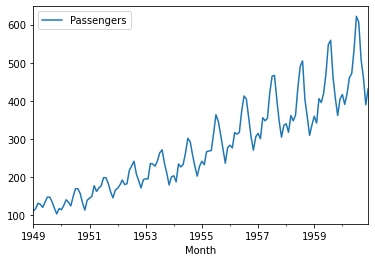

In [83]:
airline_df.plot()

<AxesSubplot:xlabel='Month'>

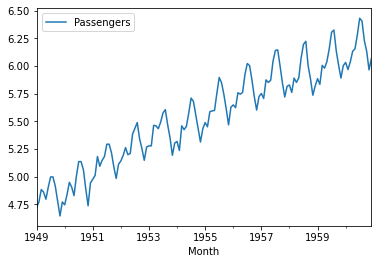

In [84]:
logged_data = np.log(airline_df)
logged_data.plot()

Has removed the growing oscillation amplitude indicating multiplicative model. Why?

The log transformation takes multiplicative growing series:

e.g:

$$ Y(t) = \exp(t)\sin(t) $$ 

and makes it additive:

$$ ln(Y[t]) = t + \ln(sin(t))$$

**linear trend + periodic function**

Now, we difference with the primary seasonal lag:
- yearly seasonality

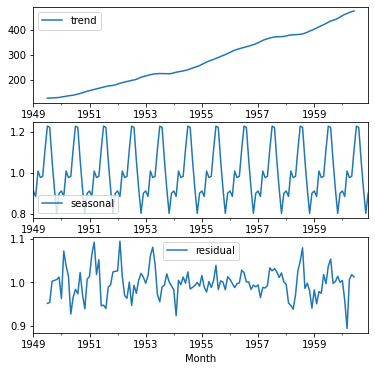

In [85]:
airline_decomposition_plot()

In [86]:
airline_df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Monthly sampling frequency: implies lag 12 for a year

Differencing at the 12th lag:
- produces an almost stationary series
- removes seasonal component of log transformed series

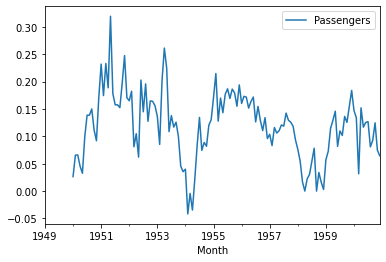

In [87]:
logged_data.diff(12).plot()
plt.show()

This log transformed seasonally differenced data seems to be somewhat non-stationary (though it's on the boundary)
- let's check with an Augmented Dickey Fuller Test

In [88]:
differenced_data =\
logged_data.diff(12).dropna()
adfuller(differenced_data)

(-2.7095768189885723,
 0.07239567181769432,
 12,
 119,
 {'1%': -3.4865346059036564,
  '5%': -2.8861509858476264,
  '10%': -2.579896092790057},
 -424.76083484995365)

A look at the ACF:

Worth looking at the ACF and the PACF of this seasonally differenced series.

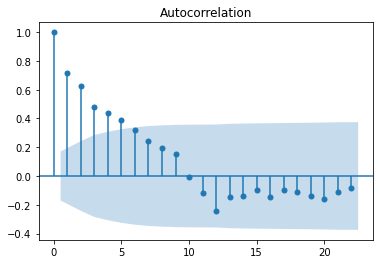

In [89]:
plot_acf(differenced_data)
plt.show()

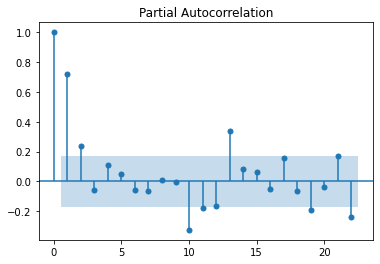

In [90]:
plot_pacf(differenced_data)
plt.show()

Seems OK. Could go to modeling: But if worried can difference (at lag 1):

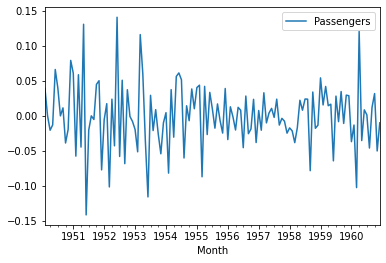

In [91]:
differenced_no_seasonality = differenced_data.diff().dropna()
differenced_no_seasonality.plot()
plt.show()

In [92]:
adfuller(differenced_no_seasonality)

(-4.443324941831103,
 0.0002485912311384249,
 12,
 118,
 {'1%': -3.4870216863700767,
  '5%': -2.8863625166643136,
  '10%': -2.580009026141913},
 -415.5597525461335)

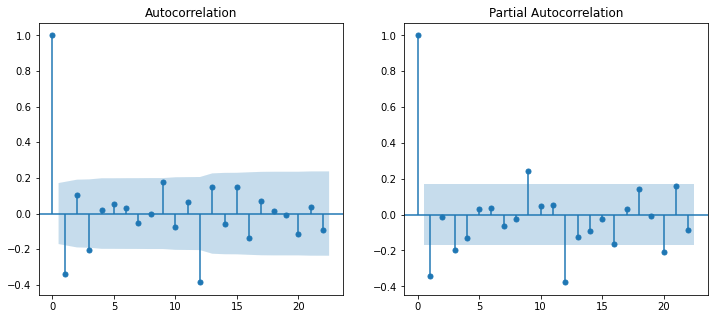

In [93]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
plot_acf(differenced_no_seasonality, ax = ax[0])
plot_pacf(differenced_no_seasonality, ax = ax[1])
plt.show()

So we have differenced at a seasonal lag and at lag 1 after log transforming:
- the number of differencing operations (and whether the differencing is seasonal) is an important parameter in time series models

The ACFs and PACFs of differenced time series will help us identify the autocorrelative/noise structure we are after:
- we'll see all these things at play when constructing classical time series models and in time series model selection.